# Титаник. Кто выживет?

https://www.kaggle.com/c/titanic/

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

### Данные

In [3]:
train = pd.read_csv('/Users/stanislav/Downloads/Sklearn/titanic/train.csv')
test = pd.read_csv('/Users/stanislav/Downloads/Sklearn/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
diff_columns = train.columns[train.dtypes==object]

In [6]:
for col in diff_columns:
    tgt = train[col].dropna()
    print(f'{col} with {tgt.nunique()} уникальных значений:\n{", ".join(pd.unique(tgt)[:6])}\n')


Name with 891 уникальных значений:
Braund, Mr. Owen Harris, Cumings, Mrs. John Bradley (Florence Briggs Thayer), Heikkinen, Miss. Laina, Futrelle, Mrs. Jacques Heath (Lily May Peel), Allen, Mr. William Henry, Moran, Mr. James

Sex with 2 уникальных значений:
male, female

Ticket with 681 уникальных значений:
A/5 21171, PC 17599, STON/O2. 3101282, 113803, 373450, 330877

Cabin with 147 уникальных значений:
C85, C123, E46, G6, C103, D56

Embarked with 3 уникальных значений:
S, C, Q



In [7]:
train.Embarked.value_counts(normalize=True, dropna=False)

S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: Embarked, dtype: float64

In [8]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# EDA

In [10]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
train.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

In [12]:
sns.boxplot?

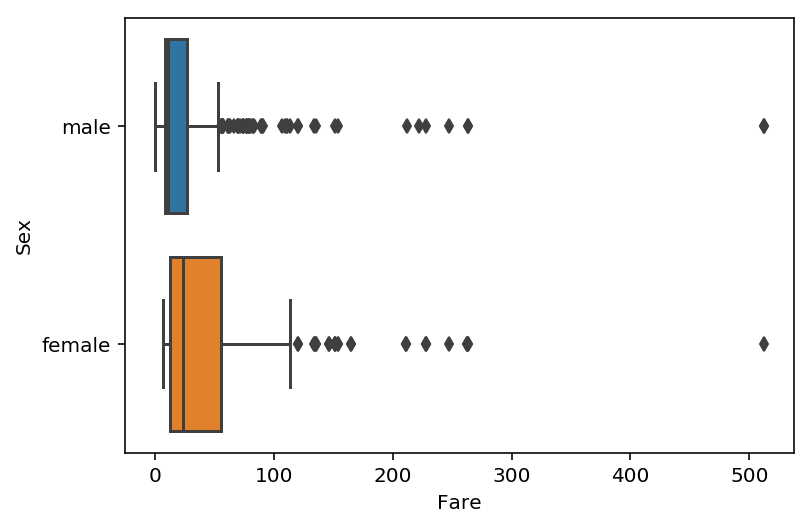

In [13]:
sns.boxplot(data=train, x='Fare', y='Sex')

In [14]:
train.groupby('Sex')['Pclass'].value_counts(normalize=True)

Sex     Pclass
female  3         0.458599
        1         0.299363
        2         0.242038
male    3         0.601386
        1         0.211438
        2         0.187175
Name: Pclass, dtype: float64

### Фичи

чтобы одинаковым образом обработать train и test и не дублировать все операции 2 раза, соединим эти два набора данных в один, не забыв при этом:
1. выкинуть целевую переменную из train
2. проверить на соответствие набора признаков друг другу
3. добавить флаг того, является ли объект тестовым или нет

In [15]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)

In [16]:
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [17]:
train['is_test'] = 0
test['is_test'] = 1

In [18]:
df = pd.concat([train, test])

супер, теперь полный набор данных можно обрабатывать вместе и в любой момент, уже обработанными, обратно разъединить на обучающую и тестовую выборки

Пол male/female закодируем в 1/0 и удалим переменные, с которыми мы не будем сейчас работать

In [19]:
df["isMale"] = df.Sex.replace({"male": 1, "female":0})
df.drop(["Sex", "Cabin", "Ticket", "Name", "PassengerId"], axis=1, inplace=True)

признаки, значения которых составляют небольшой перечислимый набор, закодируем в отдельные столбцы 

In [20]:
df.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [21]:
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked'])

In [22]:
df_dummies.head(10)

,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,0,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,0,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,0,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,0,1,0,1,0,0


In [23]:
df_dummies.isnull().sum()

Age           263
SibSp           0
Parch           0
Fare            1
is_test         0
isMale          0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [24]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [25]:
columns = X_train.columns

In [26]:
X_train.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,1,0,0,1,0,0,1
5,NaN,0,0,8.4583,1,0,0,1,0,1,0
6,54.0,0,0,51.8625,1,1,0,0,0,0,1
7,2.0,3,1,21.0750,1,0,0,1,0,0,1
8,27.0,0,2,11.1333,0,0,0,1,0,0,1
9,14.0,1,0,30.0708,0,0,1,0,1,0,0


### Заполнение пустых значений

заполним пустые значения средними по соответственным признакам

In [27]:
from sklearn.preprocessing import Imputer

In [28]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)

In [29]:
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [30]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)

In [31]:
X_train_imputed.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.000000,1.0,0.0,7.2500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.000000,1.0,0.0,71.2833,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.000000,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.000000,0.0,0.0,8.0500,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5,29.699118,0.0,0.0,8.4583,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,54.000000,0.0,0.0,51.8625,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,2.000000,3.0,1.0,21.0750,1.0,0.0,0.0,1.0,0.0,0.0,1.0
8,27.000000,0.0,2.0,11.1333,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,14.000000,1.0,0.0,30.0708,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Нормировка значений

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

In [34]:
scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
X_train_imputed_scaled = scaler.transform(X_train_imputed)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [36]:
X_train_imputed_scaled.head(10)

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
1,0.638789,0.432793,-0.473674,0.786845,-1.355574,1.767767,-0.510152,-1.107926,2.074505,-0.307562,-1.614710
2,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
3,0.407926,0.432793,-0.473674,0.420730,-1.355574,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
4,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
5,0.000000,-0.474545,-0.473674,-0.478116,0.737695,-0.565685,-0.510152,0.902587,-0.482043,3.251373,-1.614710
6,1.870059,-0.474545,-0.473674,0.395814,0.737695,1.767767,-0.510152,-1.107926,-0.482043,-0.307562,0.619306
7,-2.131568,2.247470,0.767630,-0.224083,0.737695,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
8,-0.207709,-0.474545,2.008933,-0.424256,-1.355574,-0.565685,-0.510152,0.902587,-0.482043,-0.307562,0.619306
9,-1.208115,0.432793,-0.473674,-0.042956,-1.355574,-0.565685,1.960202,-1.107926,2.074505,-0.307562,-1.614710


In [37]:
X_test_imputed_scaled = scaler.transform(imputer.transform(X_test))

### Offtop: попробуем визуализировать всех пассажиров: есть ли там кластеры?
### PCA + clustering

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=2)

In [40]:
ppl = pca.fit_transform(X_train_imputed_scaled)

всего 2 фичи объясняют 41% всего разнообразия пассажиров:

In [41]:
pca.explained_variance_ratio_.sum()

0.41017554160207326

классно, видно 6 кластеров пассажиров: внутри кластера они похожи друг на друга, межу кластерами - нет:

Text(0.5,1,'Пассажиры Титаника')

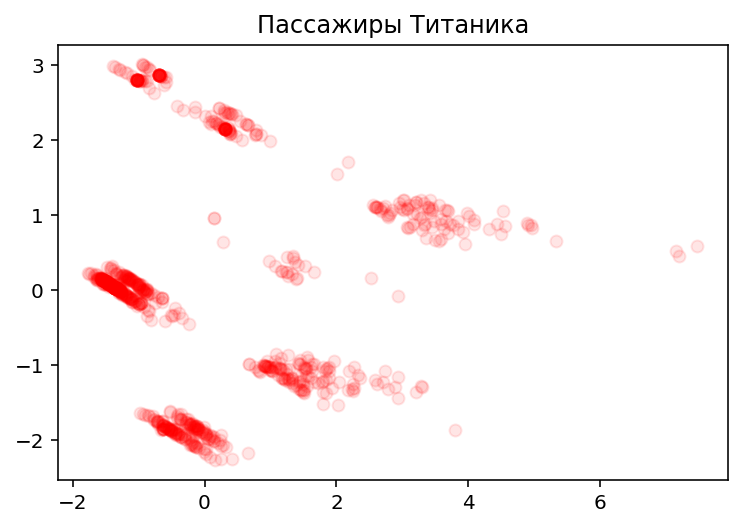

In [42]:
plt.plot(ppl[:,0], ppl[:,1], 'ro', alpha=0.1)
plt.title('Пассажиры Титаника')

можно попробовать кластеризовать по 7 кластерам и проверить, что получится:

In [43]:
from sklearn.cluster import KMeans

In [44]:
n_clusters = 7

In [45]:
kmeans = KMeans(n_clusters=n_clusters)

In [46]:
kmeans.fit(X_train_imputed_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
cluster_labels = kmeans.predict(X_train_imputed_scaled)

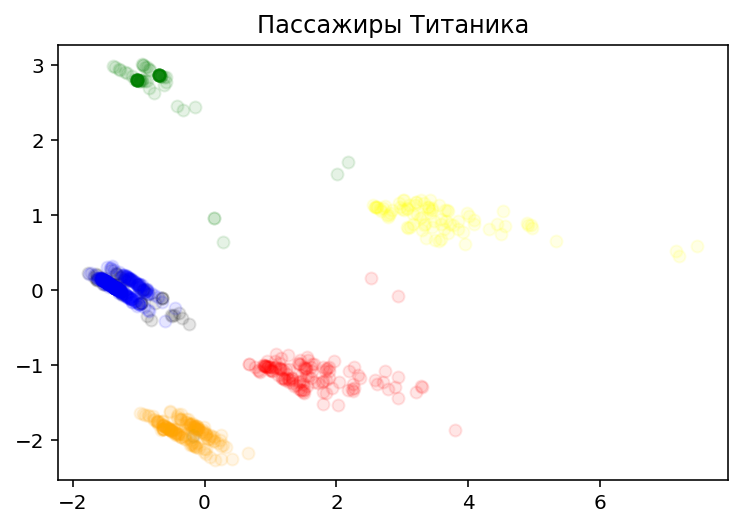

In [48]:
plt.title('Пассажиры Титаника')
for i,color in zip(range(n_clusters),{'blue','red','green','black','orange','yellow'}):
    t = ppl[cluster_labels==i]
    plt.plot(t[:,0], t[:,1], 'ro', alpha=0.1, c=color)

эти номера кластеров можно было бы подать как ещё одна фича

### Разделение на обучающую и тестирующую выборки

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)

In [51]:
X_train_fin.shape

(712, 11)

In [52]:
X_val.shape

(179, 11)

In [53]:
X_test_imputed_scaled.shape

(418, 11)

In [54]:
y_train_fin.shape

(712,)

In [55]:
y_val.shape

(179,)

### Обучение с кросс-валидацией

кросс-валидация поможет нам подобрать лучший параметр регуляризации

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [57]:
cs = 10**np.linspace(-3,1,5)
cs

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [58]:
grid = {'C': cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='accuracy', cv=5)

In [59]:
%%time
gridsearch.fit(X_train_fin, y_train_fin)

CPU times: user 229 ms, sys: 7.2 ms, total: 236 ms
Wall time: 128 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [60]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80899, std: 0.02765, params: {'C': 0.01},
 mean: 0.80758, std: 0.03096, params: {'C': 1.0},
 mean: 0.80758, std: 0.03096, params: {'C': 10.0},
 mean: 0.80478, std: 0.03414, params: {'C': 0.1},
 mean: 0.78652, std: 0.03276, params: {'C': 0.001}]

In [61]:
gridsearch.best_params_

{'C': 0.01}

In [62]:
best_C = gridsearch.best_params_["C"]

In [63]:
# деревья
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X_train_fin, y_train_fin)
print("Правильность на обучающем наборе: {:.3f}".format(tree.score(X_train_fin, y_train_fin))) 
print("Правильность на тестовом наборе: {:.3f}".format(tree.score(X_val, y_val)))


Правильность на обучающем наборе: 0.806
Правильность на тестовом наборе: 0.754


In [64]:
# случайный лес 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train_fin, y_train_fin)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [65]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train_imputed_scaled, y_train, test_size=0.2)
forest = RandomForestClassifier(n_estimators=100, random_state=0) 
forest.fit(X_train_fin, y_train_fin)
print("Правильность на обучающем наборе: {:.3f}".format(forest.score(X_train_fin, y_train_fin)))
print("Правильность на тестовом наборе: {:.3f}".format(forest.score(X_val, y_val)))

Правильность на обучающем наборе: 0.982
Правильность на тестовом наборе: 0.816


# Оценка точности

In [66]:
from sklearn.metrics import accuracy_score

In [67]:
clf = LogisticRegression(C=best_C)
clf1 = DecisionTreeClassifier(max_depth=5, random_state=0)

In [68]:
clf.fit(X_train_fin, y_train_fin)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
clf1.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [70]:
y_val_pred = clf.predict(X_val)

In [71]:
y_val_pred1 = clf1.predict(X_val)

In [72]:
accuracy_score(y_val, y_val_pred)

0.7932960893854749

In [73]:
accuracy_score(y_val, y_val_pred1)

0.8100558659217877

In [74]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_auc = roc_auc_score(y_val_pred1, forest.predict_proba(X_val)[:, 1])  
print("AUC для случайного леса: {:.3f}".format(rf_auc)) 

AUC для случайного леса: 0.916


# Финальное предсказание

In [75]:
clf.fit(X_train_imputed_scaled, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

предсказание вероятностей принадлежности классу 0 и 1:

In [76]:
clf.predict_proba(X_test_imputed_scaled)[:10]

array([[0.76740637, 0.23259363],
       [0.57619523, 0.42380477],
       [0.7005708 , 0.2994292 ],
       [0.80062122, 0.19937878],
       [0.47652336, 0.52347664],
       [0.76644721, 0.23355279],
       [0.40547278, 0.59452722],
       [0.65995123, 0.34004877],
       [0.33896628, 0.66103372],
       [0.81370895, 0.18629105]])

предсказание номера класса:

In [77]:
predictions = clf.predict(X_test_imputed_scaled)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [78]:
submussion = 'PassengerId,Survived\n'
submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(test.PassengerId, predictions)])

In [79]:
with open('submission.txt', 'w') as file:
    file.write(submussion)

In [80]:
for col, val in zip(X_train.columns, clf.coef_[0]):
    print("{:30} {:.2f}".format(col, val))

Age                            -0.20
SibSp                          -0.12
Parch                          0.00
Fare                           0.15
isMale                         -0.72
Pclass_1                       0.25
Pclass_2                       0.08
Pclass_3                       -0.28
Embarked_C                     0.08
Embarked_Q                     0.03
Embarked_S                     -0.10


Регрессия позволяет посмотреть влияние различных факторов на принятое решение. Так, видно, что женский пол, маленький возраст и первый класс являлись сильными предпосылками к выживанию